原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

# Overfitting and underfitting
# 过拟合与欠拟合

This notebook contains the code samples found in Chapter 3, Section 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


In all the examples we saw in the previous chapter -- movie review sentiment prediction, topic classification, and house price regression -- 
we could notice that the performance of our model on the held-out validation data would always peak after a few epochs and would then start 
degrading, i.e. our model would quickly start to _overfit_ to the training data. Overfitting happens in every single machine learning 
problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of 
adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" 
refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of 
course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on 
test data. While this is happening, your model is said to be _under-fit_: there is still progress to be made; the network hasn't yet 
modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops 
improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns 
that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, _the best solution is of course to get 
more training data_. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution 
is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to 
store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most 
prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called _regularization_. Let's review some of the most common regularization 
techniques, and let's apply them in practice to improve our movie classification model from  the previous chapter.


在上一章的三个例子（预测电影评论、主题分类和房价回归）中，模型在留出验证数据上的性能总是在几轮后达到最高点，然后开始下降。也就是说，模型很快就在训练数据上开始过拟合。过拟合存在于所有机器学习问题中。学会如何处理过拟合对掌握机器学习至关重要。

机器学习的根本问题是优化和泛化之间的对立。优化（optimization）是指调节模型以在训练数据上得到最佳性能（即机器学习中的学习），而泛化（generalization）是指训练好的模型在前所未见的数据上的性能好坏。机器学习的目的当然是得到良好的泛化，但你无法控制泛化，只能基于训练数据调节模型。

训练开始时，优化和泛化是相关的：训练数据上的损失越小，测试数据上的损失也越小。这时的模型是欠拟合（underfit）的，即仍有改进的空间，网络还没有对训练数据中所有相关模式建模。但在训练数据上迭代一定次数之后，泛化不再提高，验证指标先是不变，然后开始变差，即模型开始过拟合。这时模型开始学习仅和训练数据有关的模式，但这种模式对新数据来说是错误的或无关紧要的。

为了防止模型从训练数据中学到错误或无关紧要的模式，最优解决方法是获取更多的训练数据。模型的训练数据越多，泛化能力自然也越好。如果无法获取更多数据，次优解决方法是调节模型允许存储的信息量，或对模型允许存储的信息加以约束。如果一个网络只能记住几个模式，那么优化过程会迫使模型集中学习最重要的模式，这样更可能得到良好的泛化。

这种降低过拟合的方法叫作正则化（regularization）。我们先介绍几种最常见的正则化方法， 然后将其应用于实践中，以改进上一节的电影分类模型。


Note: in this notebook we will be using the IMDB test set as our validation set. It doesn't matter in this context.

Let's prepare the data using the code from Chapter 3, Section 5:

注意：在这个notebook中，我们将使用IMDB测试集作为我们的验证集。 在这种情况下关系不大。

让我们使用准备数据并使用第3章第5节中的代码：

In [2]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)（创建一个形状为 (len(sequences), dimension) 的零矩阵）
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1.（将 results[i] 的指定索引设为 1）
    return results

# Our vectorized training data（将训练数据向量化）
x_train = vectorize_sequences(train_data)
# Our vectorized test data（将测试数据向量化）
x_test = vectorize_sequences(test_data)
# Our vectorized labels（将标签向量化）
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is 
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying 
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge 
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in 
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets 
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have 
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be 
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss.

Let's try this on our movie review classification network. Our original network was as such:

# 克服过拟合
## 减小网络大小

防止过拟合的最简单的方法就是减小模型大小，即减少模型中可学习参数的个数（这由层 数和每层的单元个数决定）。在深度学习中，模型中可学习参数的个数通常被称为模型的容量（capacity）。直观上来看，参数更多的模型拥有更大的记忆容量（memorization capacity），因此能 够在训练样本和目标之间轻松地学会完美的字典式映射，这种映射没有任何泛化能力。例如，拥 有 500 000 个二进制参数的模型，能够轻松学会 MNIST 训练集中所有数字对应的类别——我们 只需让 50 000 个数字每个都对应 10 个二进制参数。但这种模型对于新数字样本的分类毫无用处。 始终牢记：深度学习模型通常都很擅长拟合训练数据，但真正的挑战在于泛化，而不是拟合。

与此相反，如果网络的记忆资源有限，则无法轻松学会这种映射。因此，为了让损失最小化，网络必须学会对目标具有很强预测能力的压缩表示，这也正是我们感兴趣的数据表示。同时请记住，你使用的模型应该具有足够多的参数，以防欠拟合，即模型应避免记忆资源不足。在容 量过大与容量不足之间要找到一个折中。

不幸的是，没有一个魔法公式能够确定最佳层数或每层的最佳大小。你必须评估一系列不 同的网络架构（当然是在验证集上评估，而不是在测试集上），以便为数据找到最佳的模型大小。 要找到合适的模型大小，一般的工作流程是开始时选择相对较少的层和参数，然后逐渐增加层的大小或增加新层，直到这种增加对验证损失的影响变得很小。

我们在电影评论分类的网络上试一下。原始网络如下所示。


In [3]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

现在我们尝试用下面这个更小的网络来替换它。

In [4]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])


Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of 
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

比较了原始网络与更小网络的验证损失。圆点是更小网络的验证损失值，十字是原 始网络的验证损失值（请记住，更小的验证损失对应更好的模型）。

In [5]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 172us/step - loss: 0.4440 - acc: 0.8251 - val_loss: 0.3286 - val_acc: 0.8835
Epoch 2/20
25000/25000 [==============================] - 4s 156us/step - loss: 0.2573 - acc: 0.9078 - val_loss: 0.2864 - val_acc: 0.8882
Epoch 3/20
25000/25000 [==============================] - 4s 147us/step - loss: 0.1991 - acc: 0.9292 - val_loss: 0.2821 - val_acc: 0.8891
Epoch 4/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.1666 - acc: 0.9412 - val_loss: 0.2939 - val_acc: 0.8844
Epoch 5/20
25000/25000 [==============================] - 4s 148us/step - loss: 0.1435 - acc: 0.9501 - val_loss: 0.3116 - val_acc: 0.8804
Epoch 6/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.1257 - acc: 0.9558 - val_loss: 0.3483 - val_acc: 0.8721
Epoch 7/20
25000/25000 [==============================] - 4s 149us/step - loss: 0.1104 - acc: 0.9615 - val_loss: 0.3598 - 

In [6]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 161us/step - loss: 0.5804 - acc: 0.7027 - val_loss: 0.5309 - val_acc: 0.7558
Epoch 2/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.4843 - acc: 0.8455 - val_loss: 0.4876 - val_acc: 0.8280
Epoch 3/20
25000/25000 [==============================] - 4s 150us/step - loss: 0.4389 - acc: 0.8920 - val_loss: 0.4663 - val_acc: 0.8497
Epoch 4/20
25000/25000 [==============================] - 4s 150us/step - loss: 0.4077 - acc: 0.9154 - val_loss: 0.4526 - val_acc: 0.8663
Epoch 5/20
25000/25000 [==============================] - 4s 154us/step - loss: 0.3832 - acc: 0.9306 - val_loss: 0.4513 - val_acc: 0.8620
Epoch 6/20
25000/25000 [==============================] - 4s 152us/step - loss: 0.3620 - acc: 0.9415 - val_loss: 0.4424 - val_acc: 0.8728
Epoch 7/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.3425 - acc: 0.9515 - val_loss: 0.4489 - 

In [7]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

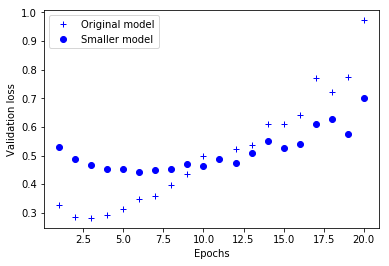

In [9]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

如你所见，更小的网络开始过拟合的时间要晚于参考网络（前者 6 轮后开始过拟合，而后者 4 轮后开始），而且开始过拟合之后，它的性能变差的速度也更慢。

现在，为了好玩，我们再向这个基准中添加一个容量更大的网络（容量远大于问题所需）。


In [10]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [11]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 10s 415us/step - loss: 0.4641 - acc: 0.7966 - val_loss: 0.2839 - val_acc: 0.8859
Epoch 2/20
25000/25000 [==============================] - 11s 439us/step - loss: 0.2229 - acc: 0.9114 - val_loss: 0.2867 - val_acc: 0.8812
Epoch 3/20
25000/25000 [==============================] - 11s 453us/step - loss: 0.1329 - acc: 0.9518 - val_loss: 0.4041 - val_acc: 0.8474
Epoch 4/20
25000/25000 [==============================] - 12s 460us/step - loss: 0.0728 - acc: 0.9786 - val_loss: 0.4165 - val_acc: 0.8822
Epoch 5/20
25000/25000 [==============================] - 11s 442us/step - loss: 0.0783 - acc: 0.9856 - val_loss: 0.4597 - val_acc: 0.8804
Epoch 6/20
25000/25000 [==============================] - 11s 446us/step - loss: 0.0024 - acc: 0.9998 - val_loss: 0.6145 - val_acc: 0.8803
Epoch 7/20
25000/25000 [==============================] - 11s 442us/step - loss: 0.0903 - acc: 0.9883 - val_loss: 0.

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the 
crosses are the initial network.

下图显示了更大的网络与参考网络的性能对比。圆点是更大网络的验证损失值，十字是原始网络的验证损失值。


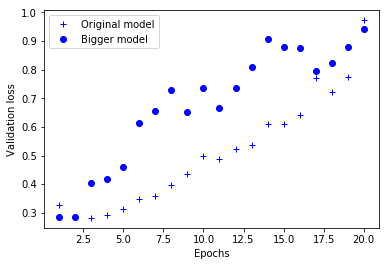

In [12]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

更大的网络只过了一轮就开始过拟合，过拟合也更严重。其验证损失的波动也更大。

下图同时给出了这两个网络的训练损失。

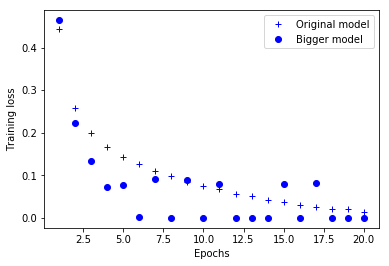

In [13]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

如你所见，更大网络的训练损失很快就接近于零。 网络的容量越大，它拟合训练数据（即得到很小的训练损失）的速度就越快，但也更容易过拟合（导致训练损失和验证损失有很大差异）。


## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different 
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight 
regularization to our movie review classification network:

## 添加权重正则化

你可能知道奥卡姆剃刀（Occam’s razor）原理：如果一件事情有两种解释，那么最可能正 确的解释就是最简单的那个，即假设更少的那个。这个原理也适用于神经网络学到的模型：给 定一些训练数据和一种网络架构，很多组权重值（即很多模型）都可以解释这些数据。简单模 型比复杂模型更不容易过拟合。

这里的简单模型（simple model）是指参数值分布的熵更小的模型（或参数更少的模型，比如上一节的例子）。因此，一种常见的降低过拟合的方法就是强制让模型权重只能取较小的值， 从而限制模型的复杂度，这使得权重值的分布更加规则（regular）。这种方法叫作权重正则化（weight regularization），其实现方法是向网络损失函数中添加与较大权重值相关的成本（cost）。 这个成本有两种形式。
* L1 正则化（L1 regularization）：添加的成本与权重系数的绝对值［权重的 L1 范数（norm）］ 成正比。
* L2 正则化（L2 regularization）：添加的成本与权重系数的平方（权重的 L2 范数）成正比。 神经网络的 L2 正则化也叫权重衰减（weight decay）。不要被不同的名称搞混，权重衰减 与 L2 正则化在数学上是完全相同的。

在 Keras 中，添加权重正则化的方法是向层传递 权重正则化项实例（weight regularizer instance）作为关键字参数。下列代码将向电影评论分类网络中添加 L2 权重正则化。


In [14]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of 
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training 
than at test time.

Here's the impact of our L2 regularization penalty:

`l2(0.001)` 的意思是该层权重矩阵的每个系数都会使网络总损失增加 `0.001 * weight_coefficient_value`。注意，由于这个惩罚项只在训练时添加，所以这个网络的训练损失会 比测试损失大很多。

下图显示了 L2 正则化惩罚的影响。


In [16]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 162us/step - loss: 0.4879 - acc: 0.8152 - val_loss: 0.3895 - val_acc: 0.8656
Epoch 2/20
25000/25000 [==============================] - 4s 152us/step - loss: 0.3100 - acc: 0.9061 - val_loss: 0.3306 - val_acc: 0.8891
Epoch 3/20
25000/25000 [==============================] - 4s 152us/step - loss: 0.2657 - acc: 0.9202 - val_loss: 0.3301 - val_acc: 0.8872
Epoch 4/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.2459 - acc: 0.9286 - val_loss: 0.3413 - val_acc: 0.8821
Epoch 5/20
25000/25000 [==============================] - 4s 152us/step - loss: 0.2323 - acc: 0.9352 - val_loss: 0.3818 - val_acc: 0.8685
Epoch 6/20
25000/25000 [==============================] - 4s 151us/step - loss: 0.2237 - acc: 0.9390 - val_loss: 0.3676 - val_acc: 0.8752
Epoch 7/20
25000/25000 [==============================] - 4s 153us/step - loss: 0.2173 - acc: 0.9409 - val_loss: 0.3748 - 

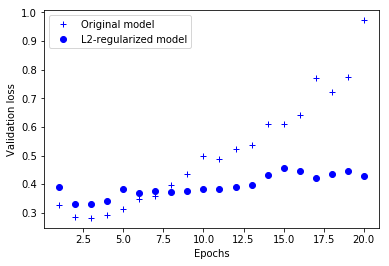

In [17]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), 
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

如你所见，即使两个模型的参数个数相同，具有 L2正则化的模型（圆点）比参考模型（十字）更不容易过拟合。

你还可以用 Keras 中以下这些权重正则化项来代替 L2 正则化。


In [18]:
from keras import regularizers

# L1 regularization（L1 正则化）
regularizers.l1(0.001)

# L1 and L2 regularization at the same time（同时做 L1 和 L2 正则化）
regularizers.l1_l2(l1=0.001, l2=0.001)

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his 
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of 
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a 
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5,1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test 
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to 
balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, `layer_output`, of shape `(batch_size, features)`. At training time, we would be 
zero-ing out at random a fraction of the values in the matrix:

## 添加 dropout 正则化

dropout 是神经网络最有效也最常用的正则化方法之一，它是由多伦多大学的 Geoffrey Hinton和他的学生开发的。对某一层使用 dropout，就是在训练过程中随机将该层的一些输出特征舍弃（设置为 0）。假设在训练过程中，某一层对给定输入样本的返回值应该是向量 `[0.2, 0.5, 1.3, 0.8, 1.1]`。使用 dropout 后，这个向量会有几个随机的元素变成 0，比如 `[0, 0.5,1.3, 0, 1.1]`。dropout 比率（dropout rate）是被设为 0 的特征所占的比例，通常在 0.2~0.5 范围内。测试时没有单元被舍弃，而该层的输出值需要按 dropout 比率缩小，因为这时比训练时有更多的单元被激活，需要加以平衡。

假设有一个包含某层输出的 Numpy 矩阵 `layer_output`，其形状为 `(batch_size, features)`。训练时，我们随机将矩阵中一部分值设为 0。



At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the 
units):

测试时，我们将输出按 dropout 比率缩小。这里我们乘以 0.5（因为前面舍弃了一半的单元）。


Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is 
often the way it is implemented in practice:

注意，为了实现这一过程，还可以让两个运算都在训练时进行，而测试时输出保持不变。这通常也是实践中的实现方式：



This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among 
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked 
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation 
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each 
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what 
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

这一方法可能看起来有些奇怪和随意。它为什么能够降低过拟合？ Hinton 说他的灵感之一来自于银行的防欺诈机制。用他自己的话来说：“我去银行办理业务。柜员不停地换人，于是我问其中一人这是为什么。他说他不知道，但他们经常换来换去。我猜想，银行工作人员要想成功欺诈银行，他们之间要互相合作才行。这让我意识到，在每个样本中随机删除不同的部分神经元，可以阻止它们的阴谋，因此可以降低过拟合。”

其核心思想是在层的输出值中引入噪声， 打破不显著的偶然模式（Hinton 称之为阴谋）。如果没有噪声的话，网络将会记住这些偶然模式。

在 Keras 中，你可以通过 Dropout 层向网络中引入 dropout，dropout 将被应用于前面一层的输出。


Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

我们向 IMDB 网络中添加两个 Dropout 层，来看一下它们降低过拟合的效果。

In [20]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [21]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 5s 181us/step - loss: 0.5906 - acc: 0.6839 - val_loss: 0.4324 - val_acc: 0.8620
Epoch 2/20
25000/25000 [==============================] - 4s 150us/step - loss: 0.4359 - acc: 0.8186 - val_loss: 0.3475 - val_acc: 0.8706
Epoch 3/20
25000/25000 [==============================] - 4s 154us/step - loss: 0.3469 - acc: 0.8714 - val_loss: 0.2912 - val_acc: 0.8872
Epoch 4/20
25000/25000 [==============================] - 4s 153us/step - loss: 0.2880 - acc: 0.8983 - val_loss: 0.2768 - val_acc: 0.8881
Epoch 5/20
25000/25000 [==============================] - 4s 153us/step - loss: 0.2531 - acc: 0.9135 - val_loss: 0.2805 - val_acc: 0.8883
Epoch 6/20
25000/25000 [==============================] - 4s 155us/step - loss: 0.2220 - acc: 0.9265 - val_loss: 0.2892 - val_acc: 0.8877
Epoch 7/20
25000/25000 [==============================] - 4s 156us/step - loss: 0.1965 - acc: 0.9355 - val_loss: 0.3208 - 

Let's plot the results:

我们将结果绘制出来：

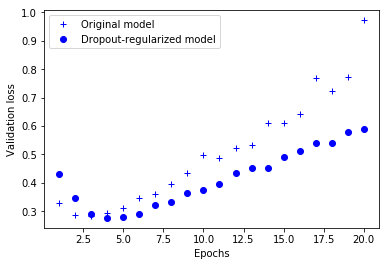

In [22]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.

我们再次看到，这种方法的性能相比参考网络有明显提高。

总结一下，防止神经网络过拟合的常用方法包括：
* 获取更多的训练数据
* 减小网络容量
* 添加权重正则化
* 添加 dropout
